## Requirement

In [30]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 2.1 MB/s eta 0:00:001.8 MB/s eta 0:00:01m
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pptx import Presentation
import PyPDF2
from wordcloud import WordCloud

# Download stopwords if not done
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/amartya-
[nltk_data]     pandey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loader

In [2]:
class DataLoader:
    """Load text data and labels from a directory and its subdirectories."""
    
    def __init__(self, directory):
        self.directory = directory

    def load_data(self):
        text_data, labels = [], []
        
        # Iterate through each subdirectory in the main directory
        for label in os.listdir(self.directory):
            label_dir = os.path.join(self.directory, label)
            if os.path.isdir(label_dir):  # Check if it's a directory
                for filename in os.listdir(label_dir):
                    file_path = os.path.join(label_dir, filename)
                    
                    if filename.endswith('.txt'):
                        with open(file_path, 'r', encoding='utf-8') as file:
                            text_data.append(file.read())
                        labels.append(label)

                    elif filename.endswith('.pdf'):
                        with open(file_path, 'rb') as file:
                            reader = PyPDF2.PdfReader(file)
                            content = ''.join(page.extract_text() for page in reader.pages)
                            text_data.append(content.strip())
                        labels.append(label)

                    elif filename.endswith('.pptx'):
                        presentation = Presentation(file_path)
                        content = ''.join(
                            shape.text for slide in presentation.slides for shape in slide.shapes if hasattr(shape, "text")
                        )
                        text_data.append(content.strip())
                        labels.append(label)

        return np.array(text_data), np.array(labels)

## Preprocessor

In [4]:
class Preprocessor:
    """Preprocess text and encode labels."""

    def __init__(self, ngram_range=(1, 1)):
        self.vectorizer = CountVectorizer(ngram_range=ngram_range)
        self.label_encoder = LabelEncoder()
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        return re.sub(r'[^a-zA-Z\s]', '', text.lower())

    def tokenize(self, text):
        return text.split()

    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.stop_words]

    def stem_tokens(self, tokens):
        return [self.stemmer.stem(word) for word in tokens]

    def preprocess_text(self, text_data):
        processed_data = []
        for text in text_data:
            tokens = self.stem_tokens(self.remove_stopwords(self.tokenize(self.clean_text(text))))
            processed_data.append(' '.join(tokens))
        return processed_data

    def count_vectorize(self, text_data):
        processed_data = self.preprocess_text(text_data)
        return self.vectorizer.fit_transform(processed_data)

    def encode_labels(self, labels):
        return self.label_encoder.fit_transform(labels)


## Model

In [5]:
class Model:
    """Train a Decision Tree model."""

    def __init__(self, max_depth=None, min_samples_split=2):
        self.model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

    def train(self, X, y):
        """Train the model using dynamically adjusted Stratified K-Fold cross-validation."""
        # Dynamically adjust the number of splits to avoid errors with small classes but also ensuring at least 2 splits to avoid errors
        n_splits = max(2, min(5, np.min(np.bincount(y))))  # At least 2 splits, at most 5 or the smallest class size

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        scores = cross_val_score(self.model, X, y, cv=skf, scoring='accuracy')
        print(f'Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}')
        # Fit the model on the entire dataset after cross-validation
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def get_feature_importances(self):
        return self.model.feature_importances_


## Evaluator

In [6]:
class Evaluator:
    """Evaluate model performance and visualize results."""

    def __init__(self, label_encoder):
        self.label_encoder = label_encoder

    def evaluate(self, y_true, y_pred):
        """Evaluate model performance."""
        print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')
        print('Classification Report:\n', classification_report(y_true, y_pred, target_names=self.label_encoder.classes_))

        cm = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix(cm)

    def plot_confusion_matrix(self, cm):
        """Plot confusion matrix with percentages."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=self.label_encoder.classes_, yticklabels=self.label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_feature_importance(self, model, feature_names):
        """Plot feature importances for tree-based models."""
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_features = [feature_names[i] for i in indices]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=importances[indices], y=top_features, palette='viridis')
        plt.title('Feature Importances')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()

    def plot_learning_curve(self, model, X, y):
        """Plot learning curve for training vs cross-validation accuracy."""
        from sklearn.model_selection import learning_curve

        train_sizes, train_scores, valid_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
        )

        train_mean = np.mean(train_scores, axis=1)
        valid_mean = np.mean(valid_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
        plt.plot(train_sizes, valid_mean, 'o-', color='red', label='Validation Accuracy')
        plt.title('Learning Curve')
        plt.xlabel('Training Examples')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

## EDA

In [7]:
def perform_eda(text_data, labels):
    """Perform exploratory data analysis on the dataset."""
    print("Number of documents:", len(text_data))
    print("Number of unique labels:", len(np.unique(labels)))

    # Document length distribution
    doc_lengths = [len(doc.split()) for doc in text_data]
    plt.figure(figsize=(10, 5))
    sns.histplot(doc_lengths, bins=30, kde=True, color='skyblue')
    plt.title('Document Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

    # Label distribution
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Word Cloud of text data
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Text Data')
    plt.show()

    # N-gram analysis (unigrams and bigrams)
    vectorizer = CountVectorizer(ngram_range=(1, 2))
    X_ngrams = vectorizer.fit_transform(text_data)
    ngram_counts = X_ngrams.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = pd.DataFrame({'ngram': ngram_features, 'count': ngram_counts})
    top_ngrams = ngram_freq.sort_values(by='count', ascending=False).head(20)


    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='ngram', data=top_ngrams)  # Simplified plot
    plt.title('Top 20 N-grams')
    plt.xlabel('Count')
    plt.ylabel('N-grams')
    plt.show()


## Main func

Number of documents: 2525
Number of unique labels: 5


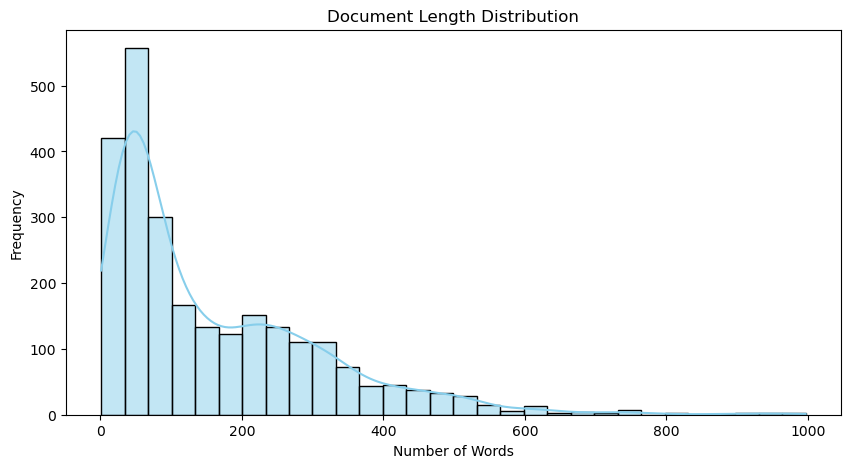

/tmp/ipykernel_8024/4160558422.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


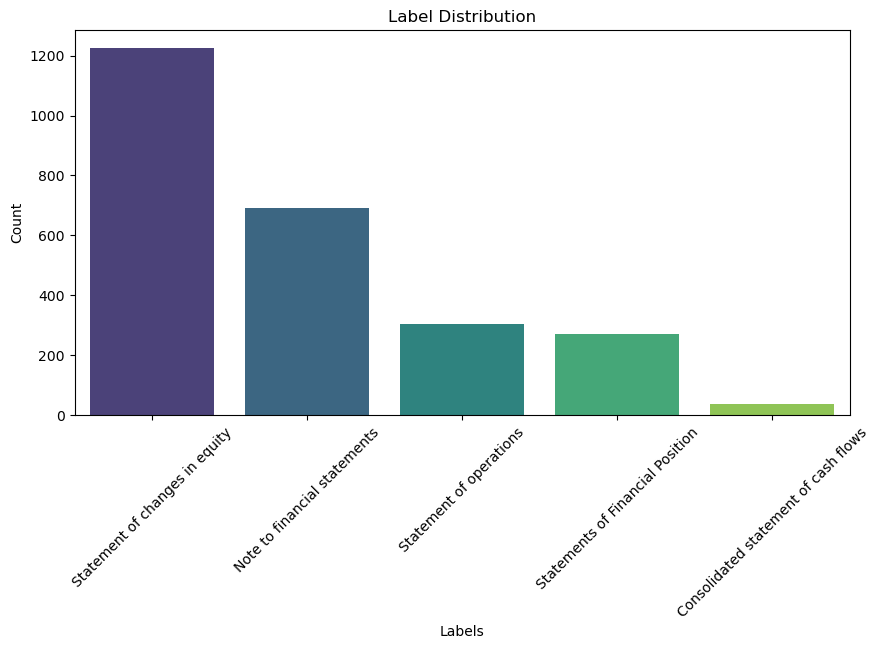

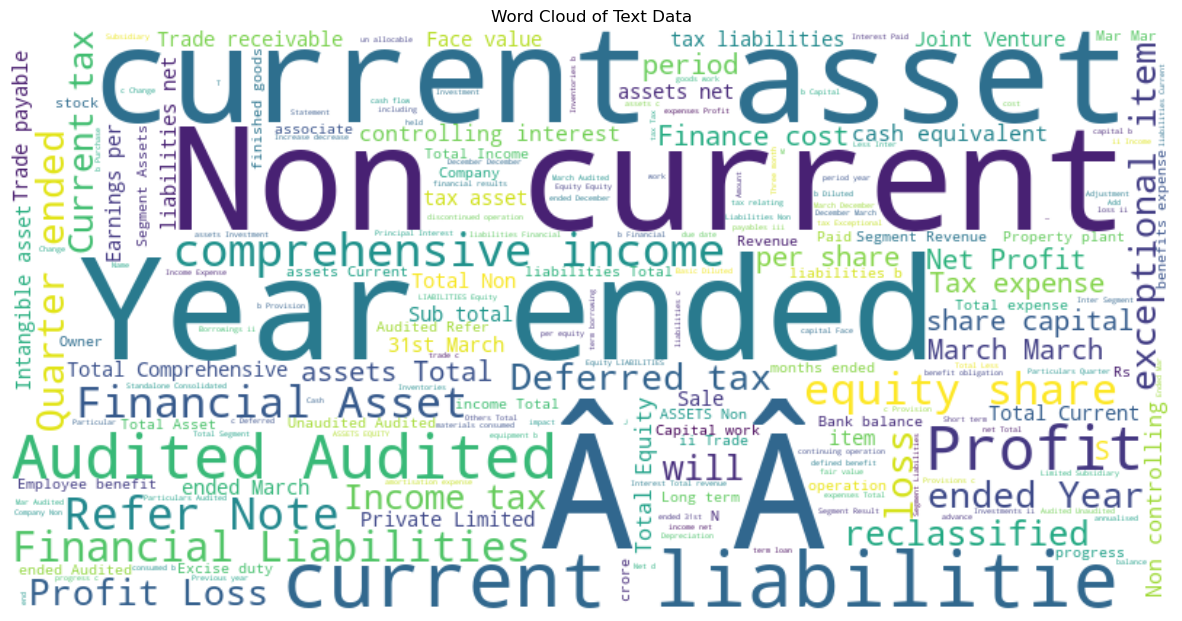

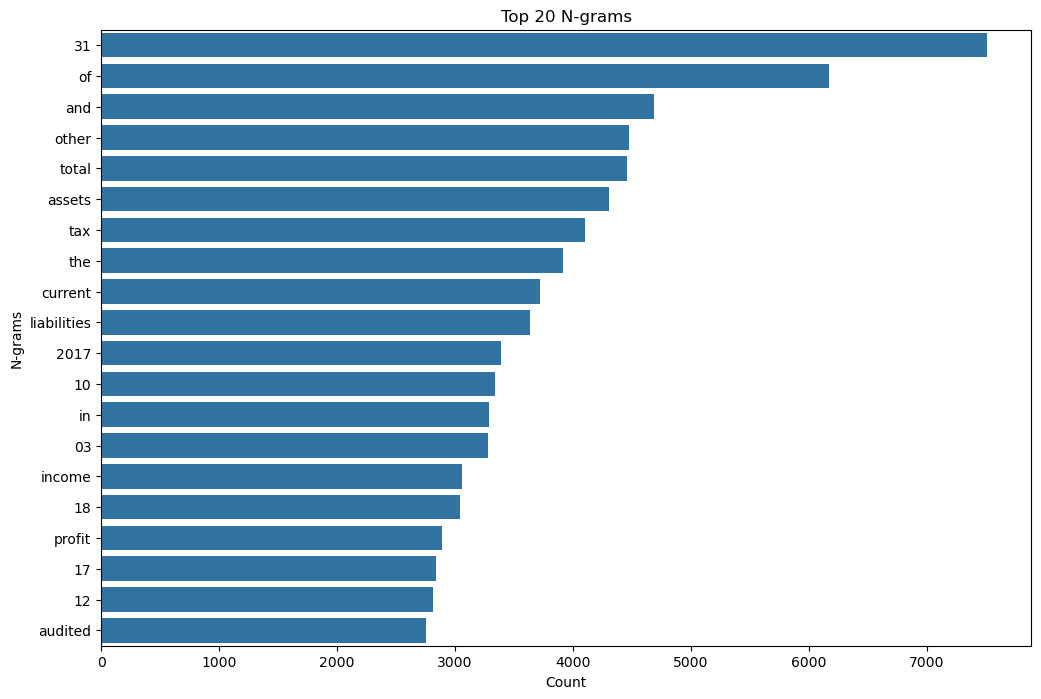

Cross-Validation Accuracy: 0.87 ± 0.01
Accuracy: 0.92
Classification Report:
                                       precision    recall  f1-score   support

Consolidated statement of cash flows       1.00      0.94      0.97        36
        Note to financial statements       0.86      0.88      0.87       690
      Statement of changes in equity       0.92      0.93      0.93      1224
             Statement of operations       1.00      0.95      0.98       305
    Statements of Financial Position       0.99      0.96      0.97       270

                            accuracy                           0.92      2525
                           macro avg       0.96      0.93      0.94      2525
                        weighted avg       0.92      0.92      0.92      2525



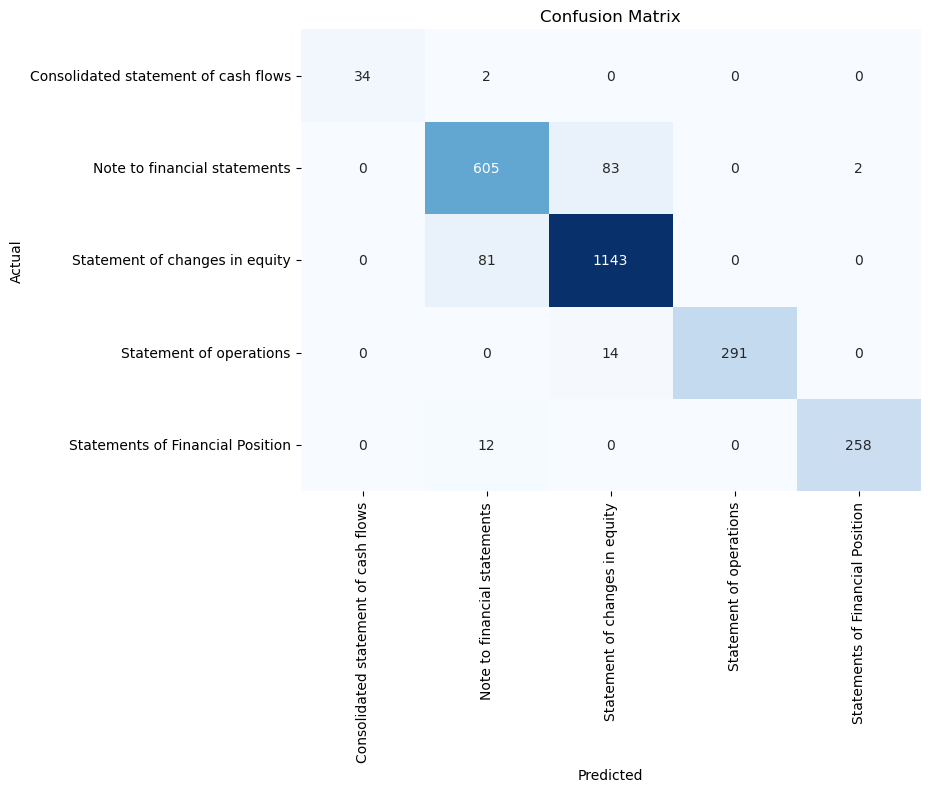

/tmp/ipykernel_8024/1361072569.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=top_features, palette='viridis')


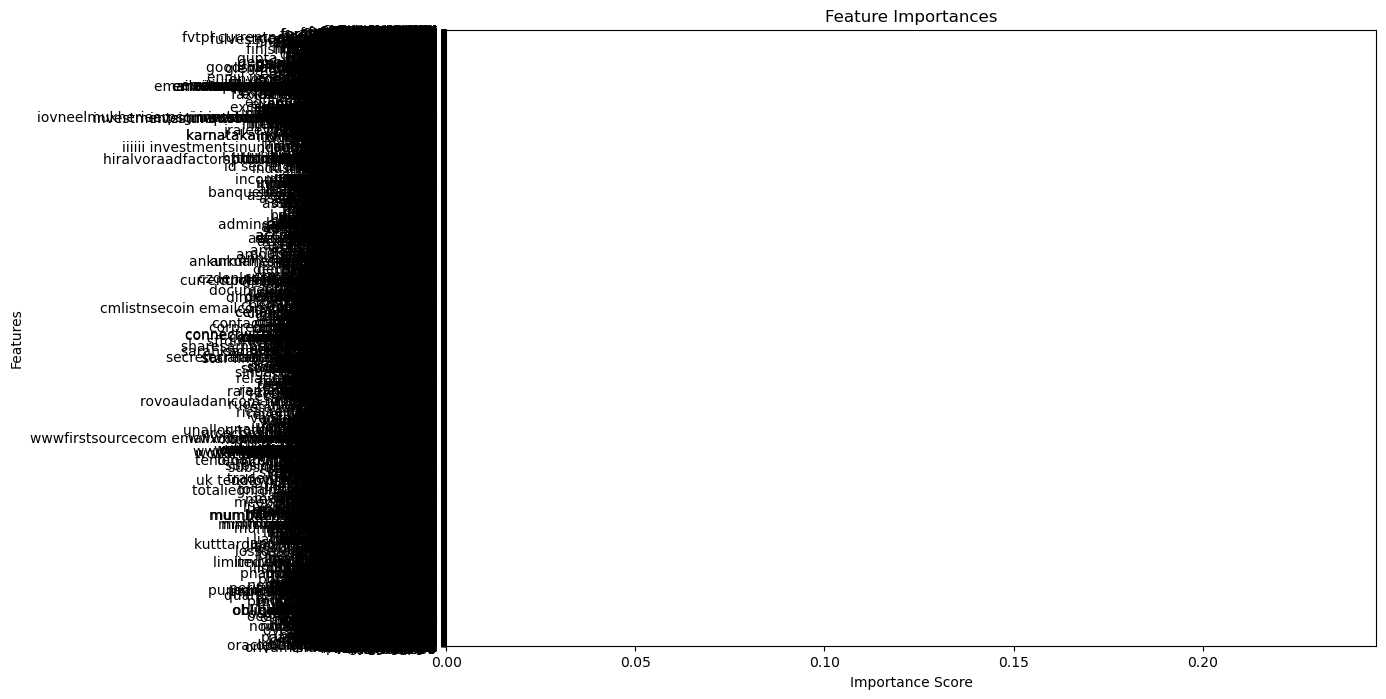

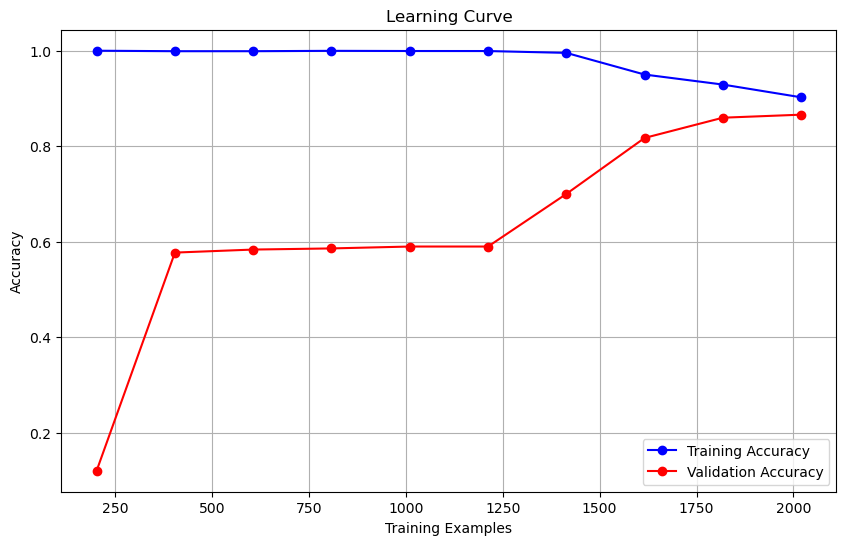

In [10]:
def main():
    directory_path = r'data'
    data_loader = DataLoader(directory_path)
    text_data, labels = data_loader.load_data()

    # Perform EDA
    perform_eda(text_data, labels)

    # Preprocess and vectorize
    preprocessor = Preprocessor(ngram_range=(1, 2))
    X = preprocessor.count_vectorize(text_data)
    y = preprocessor.encode_labels(labels)

    # Train model
    model = Model(max_depth=10, min_samples_split=5)
    model.train(X, y)

    # Evaluate model
    evaluator = Evaluator(preprocessor.label_encoder)
    y_pred = model.predict(X)
    evaluator.evaluate(y, y_pred)

    # Post-training insights
    feature_names = preprocessor.vectorizer.get_feature_names_out()
    evaluator.plot_feature_importance(model.model, feature_names)
    evaluator.plot_learning_curve(model.model, X, y)

    # Save model and vectorizer
    with open('model.dill', 'wb') as f:
        dill.dump(model.model, f)
    with open('vectorizer.dill', 'wb') as f:
        dill.dump(preprocessor.vectorizer, f)


if __name__ == '__main__':
    main()